In [1]:


import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('./data/data_'+'Chennai'+'.csv')
print(df.head()) #3 columns, including the Date. 


                  Date    no2    so2  pm2_5    pm10     o3   nh3     no
0  2020-11-25 00:00:00   8.69  11.22  19.62   21.07  71.72  0.78   0.02
1  2020-11-26 00:00:00  10.79  14.83  22.15   23.48  72.51  0.73   0.02
2  2020-11-27 00:00:00  23.69  11.84  37.88   44.47  38.35  3.44   3.55
3  2020-11-28 00:00:00  43.94  35.79  94.98  106.19  20.55  4.34  23.08
4  2020-11-29 00:00:00  21.80  23.07  36.83   42.77  37.15  2.27   1.27


In [3]:

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 


662   2022-09-19
663   2022-09-20
664   2022-09-21
665   2022-09-22
666   2022-09-23
667   2022-09-24
668   2022-09-25
669   2022-09-26
670   2022-09-27
671   2022-09-28
672   2022-09-29
673   2022-09-30
674   2022-10-01
675   2022-10-02
676   2022-10-03
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:5]
#Date and volume columns are not used in training. 
print(cols) #['pm10', 'pm10', 'pm10']


['no2', 'so2', 'pm2_5', 'pm10']


<AxesSubplot: >

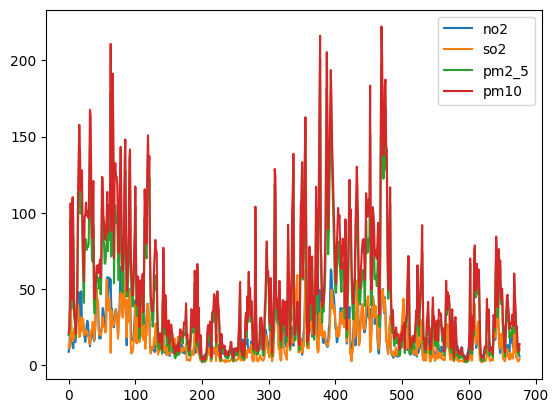

In [5]:
#New dataframe with only training data - 3 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training
df_for_plot.plot.line()


In [6]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [7]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [8]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

 




trainX shape == (663, 14, 4).
trainY shape == (663, 1).


In [9]:
trainX

array([[[-0.83636885, -0.42692021, -0.63602705, -0.72325298],
        [-0.66315258, -0.15427223, -0.56801613, -0.66662265],
        [ 0.40089021, -0.38009424, -0.14516562, -0.17339834],
        ...,
        [ 0.32088079,  0.80717063, -0.67903791, -0.74134648],
        [ 1.33873257,  1.70592711, -0.19167111, -0.28548409],
        [ 1.31233771,  1.69157722,  0.10134037,  0.01576106]],

       [[-0.66315258, -0.15427223, -0.56801613, -0.66662265],
        [ 0.40089021, -0.38009424, -0.14516562, -0.17339834],
        [ 2.07118993,  1.42874759,  1.38978441,  1.27690201],
        ...,
        [ 1.33873257,  1.70592711, -0.19167111, -0.28548409],
        [ 1.31233771,  1.69157722,  0.10134037,  0.01576106],
        [ 1.4839043 ,  1.73689267,  1.34220365,  1.33541218]],

       [[ 0.40089021, -0.38009424, -0.14516562, -0.17339834],
        [ 2.07118993,  1.42874759,  1.38978441,  1.27690201],
        [ 0.24499557,  0.46805999, -0.1733915 , -0.21334504],
        ...,
        [ 1.31233771,  1.69

In [10]:
trainY

array([[ 1.48390430e+00],
       [ 2.39865116e+00],
       [ 1.33213386e+00],
       [ 5.65858083e-01],
       [ 5.78230674e-01],
       [ 2.44071797e+00],
       [ 5.68332601e-01],
       [ 7.74542444e-01],
       [ 6.32670072e-01],
       [ 2.14640992e-02],
       [-3.62746567e-02],
       [-3.01872934e-01],
       [ 1.89731331e-01],
       [ 6.16173285e-01],
       [ 8.47128308e-01],
       [ 7.12679491e-01],
       [ 9.40499638e-02],
       [-1.23707630e-01],
       [-5.43550869e-01],
       [-1.62475080e-01],
       [-1.27006987e-01],
       [ 7.92028551e-02],
       [ 2.81288501e-01],
       [ 6.06275212e-01],
       [-2.59806126e-01],
       [-1.83096064e-01],
       [ 5.13893203e-01],
       [ 1.77589744e+00],
       [ 2.27245074e+00],
       [ 1.70826061e+00],
       [ 1.84930814e+00],
       [ 6.63189129e-01],
       [-1.21233112e-01],
       [-6.59688740e-02],
       [-1.04736324e-01],
       [ 3.68721474e-01],
       [ 6.07924891e-01],
       [ 1.53586918e+00],
       [ 1.4

In [11]:
print(trainX.shape[1], trainX.shape[2])

14 4


In [12]:
# define the Autoencoder model
model1 = Sequential()
model1.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY.shape[1]))

model1.compile(optimizer='adam', loss='mse')
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
38/38 [==============================] - 2s 11ms/step - loss: 0.7599 - val_loss: 0.3263
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6290 - val_loss: 0.3021
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.5692 - val_loss: 0.2772
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.5521 - val_loss: 0.2591
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4944 - val_loss: 0.3206
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4632 - val_loss: 0.2780
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4101 - val_loss: 0.2364
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3845 - val_loss: 0.2274
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3865 - val_loss: 0.2147
Epoch 10/100
38/38 [==============================] - 0s 5ms/step - loss: 0.3804 - val_loss: 0.1957
Epoch 11

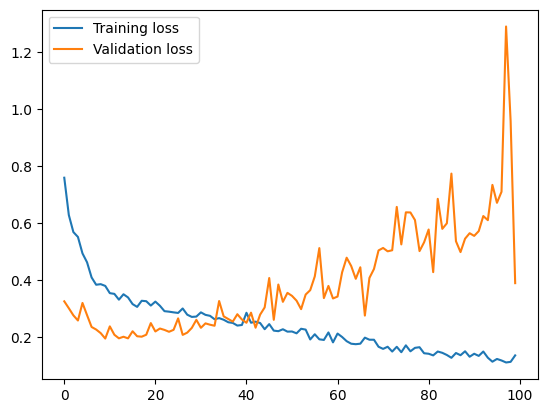

In [13]:

# fit the model
history = model1.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()




In [14]:
# Save the entire model as a SavedModel.
!mkdir saved_model
model1.save('saved_model/my_model_1_5.h5')

A subdirectory or file saved_model already exists.


In [15]:
model = tf.keras.models.load_model('saved_model/lstm_model_Chennai.h5')

In [16]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)


[Timestamp('2022-09-18 00:00:00', freq='D'), Timestamp('2022-09-19 00:00:00', freq='D'), Timestamp('2022-09-20 00:00:00', freq='D'), Timestamp('2022-09-21 00:00:00', freq='D'), Timestamp('2022-09-22 00:00:00', freq='D'), Timestamp('2022-09-23 00:00:00', freq='D'), Timestamp('2022-09-24 00:00:00', freq='D'), Timestamp('2022-09-25 00:00:00', freq='D'), Timestamp('2022-09-26 00:00:00', freq='D'), Timestamp('2022-09-27 00:00:00', freq='D'), Timestamp('2022-09-28 00:00:00', freq='D'), Timestamp('2022-09-29 00:00:00', freq='D'), Timestamp('2022-09-30 00:00:00', freq='D'), Timestamp('2022-10-01 00:00:00', freq='D'), Timestamp('2022-10-02 00:00:00', freq='D')]


In [17]:

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,2]


1/1 [==============================] - 0s 186ms/step


In [18]:
prediction_copies

array([[-6.5683573e-01, -6.5683573e-01, -6.5683573e-01, -6.5683573e-01],
       [-4.4205773e-01, -4.4205773e-01, -4.4205773e-01, -4.4205773e-01],
       [-4.1789290e-01, -4.1789290e-01, -4.1789290e-01, -4.1789290e-01],
       [-2.6564899e-01, -2.6564899e-01, -2.6564899e-01, -2.6564899e-01],
       [-1.6914283e-01, -1.6914283e-01, -1.6914283e-01, -1.6914283e-01],
       [-2.8150952e-01, -2.8150952e-01, -2.8150952e-01, -2.8150952e-01],
       [-2.0575091e-01, -2.0575091e-01, -2.0575091e-01, -2.0575091e-01],
       [ 4.6876732e-02,  4.6876732e-02,  4.6876732e-02,  4.6876732e-02],
       [-4.2430383e-01, -4.2430383e-01, -4.2430383e-01, -4.2430383e-01],
       [-3.8321316e-04, -3.8321316e-04, -3.8321316e-04, -3.8321316e-04],
       [-4.0961611e-01, -4.0961611e-01, -4.0961611e-01, -4.0961611e-01],
       [-3.2005817e-01, -3.2005817e-01, -3.2005817e-01, -3.2005817e-01],
       [-3.4446496e-01, -3.4446496e-01, -3.4446496e-01, -3.4446496e-01],
       [-3.4246111e-01, -3.4246111e-01, -3.4246111e

In [19]:
prediction

array([[-6.5683573e-01],
       [-4.4205773e-01],
       [-4.1789290e-01],
       [-2.6564899e-01],
       [-1.6914283e-01],
       [-2.8150952e-01],
       [-2.0575091e-01],
       [ 4.6876732e-02],
       [-4.2430383e-01],
       [-3.8321316e-04],
       [-4.0961611e-01],
       [-3.2005817e-01],
       [-3.4446496e-01],
       [-3.4246111e-01],
       [-3.5507563e-01]], dtype=float32)

#pm2_5

In [21]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'pm2_5':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'pm2_5']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['pm2_5'])
sns.lineplot(df_forecast['Date'], df_forecast['pm2_5'])


C:\Users\nithi\AppData\Local\Temp\ipykernel_10816\1430679471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

In [22]:
df_forecast

,Date,pm2_5
0,2022-09-18,18.845919
1,2022-09-19,26.835640
2,2022-09-20,27.734570
3,2022-09-21,33.398029
4,2022-09-22,36.988049
5,2022-09-23,32.808022
6,2022-09-24,35.626232
7,2022-09-25,45.023956
8,2022-09-26,27.496084
9,2022-09-27,43.265892


In [23]:
original.tail(16)

,Date,pm2_5
661,2022-09-18,17.87
662,2022-09-19,20.77
663,2022-09-20,21.26
664,2022-09-21,19.16
665,2022-09-22,25.15
666,2022-09-23,23.91
667,2022-09-24,21.10
668,2022-09-25,53.54
669,2022-09-26,41.81
670,2022-09-27,32.37


In [24]:
org=original.tail(16).copy()
org=org.head(15)
org = org.reset_index()
org

,index,Date,pm2_5
0,661,2022-09-18,17.87
1,662,2022-09-19,20.77
2,663,2022-09-20,21.26
3,664,2022-09-21,19.16
4,665,2022-09-22,25.15
5,666,2022-09-23,23.91
6,667,2022-09-24,21.10
7,668,2022-09-25,53.54
8,669,2022-09-26,41.81
9,670,2022-09-27,32.37


In [25]:
predict_final = pd.DataFrame(columns=['Date','Actuall','Predicted','def','errorPersent'])
predict_final

,Date,Actuall,Predicted,def,errorPersent


In [26]:
print(df_forecast.shape)
for i in range(df_forecast.shape[0]):
    def2=df_forecast['pm2_5'][i]-org['pm2_5'][i]
    if(def2<0):
        def2=def2*-1
    if(org['pm2_5'][i]>df_forecast['pm2_5'][i]):
        error=(def2/org['pm2_5'][i])*100
    else:
        error=(def2/df_forecast['pm2_5'][i])*100
    data1 = {
        "Date": [df_forecast['Date'][i]],
        "Actuall":org['pm2_5'][i],
        "Predicted":df_forecast['pm2_5'][i],
        "def":def2,
        "errorPersent":error
            }
    print(data1)
    data = pd.DataFrame(data1)

    predict_final = pd.concat([predict_final, data])
    


(15, 2)
{'Date': [Timestamp('2022-09-18 00:00:00')], 'Actuall': 17.87, 'Predicted': 18.845919, 'def': 0.9759186553955068, 'errorPersent': 5.1784085097709225}
{'Date': [Timestamp('2022-09-19 00:00:00')], 'Actuall': 20.77, 'Predicted': 26.83564, 'def': 6.065639953613282, 'errorPersent': 22.60292642209404}
{'Date': [Timestamp('2022-09-20 00:00:00')], 'Actuall': 21.26, 'Predicted': 27.73457, 'def': 6.474569549560545, 'errorPersent': 23.344763069031064}
{'Date': [Timestamp('2022-09-21 00:00:00')], 'Actuall': 19.16, 'Predicted': 33.39803, 'def': 14.238029327392578, 'errorPersent': 42.63134566360403}
{'Date': [Timestamp('2022-09-22 00:00:00')], 'Actuall': 25.15, 'Predicted': 36.98805, 'def': 11.838048553466798, 'errorPersent': 32.00506384205351}
{'Date': [Timestamp('2022-09-23 00:00:00')], 'Actuall': 23.91, 'Predicted': 32.80802, 'def': 8.898021545410156, 'errorPersent': 27.12148165683886}
{'Date': [Timestamp('2022-09-24 00:00:00')], 'Actuall': 21.1, 'Predicted': 35.626232, 'def': 14.52623214

In [27]:
predict_final = predict_final.reset_index()
predict_final

,index,Date,Actuall,Predicted,def,errorPersent
0,0,2022-09-18,17.87,18.845919,0.975919,5.178409
1,0,2022-09-19,20.77,26.835640,6.065640,22.602926
2,0,2022-09-20,21.26,27.734570,6.474570,23.344763
3,0,2022-09-21,19.16,33.398029,14.238029,42.631346
4,0,2022-09-22,25.15,36.988049,11.838049,32.005064
5,0,2022-09-23,23.91,32.808022,8.898022,27.121482
6,0,2022-09-24,21.10,35.626232,14.526232,40.773978
7,0,2022-09-25,53.54,45.023956,8.516044,15.905946
8,0,2022-09-26,41.81,27.496084,14.313916,34.235627
9,0,2022-09-27,32.37,43.265892,10.895892,25.183560


In [28]:
print("Total error persentage : ",(predict_final['errorPersent'].sum())/15)
print('model accurace : ',100-(predict_final['errorPersent'].sum())/15)

Total error persentage :  36.5582835085256
model accurace :  63.4417164914744


#pm10

In [ ]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,3]

C:\Users\HAPPY\AppData\Local\Temp\ipykernel_16080\1710788500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`,

<AxesSubplot:xlabel='Date', ylabel='pm10'>

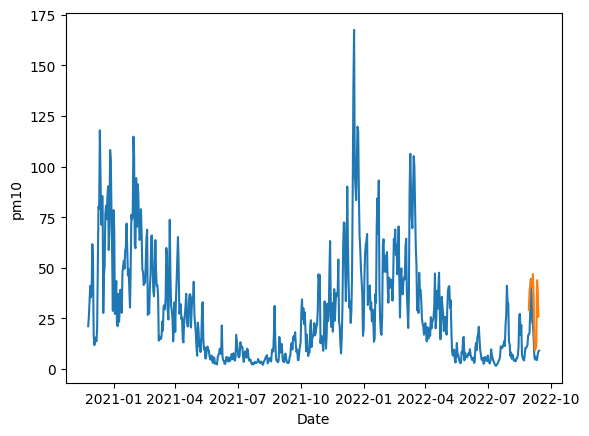

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'pm10':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'pm10']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['pm10'])
sns.lineplot(df_forecast['Date'], df_forecast['pm10'])


In [ ]:
df_forecast

,Date,pm10
0,2022-08-30,29.163513
1,2022-08-31,38.223301
2,2022-09-01,41.628132
3,2022-09-02,43.779839
4,2022-09-03,44.620266
5,2022-09-04,40.614212
6,2022-09-05,46.925884
7,2022-09-06,36.483101
8,2022-09-07,15.834968
9,2022-09-08,9.218567


In [ ]:
original.tail(16)

,Date,pm10
643,2022-08-30,17.04
644,2022-08-31,17.97
645,2022-09-01,27.93
646,2022-09-02,44.54
647,2022-09-03,36.94
648,2022-09-04,23.25
649,2022-09-05,21.99
650,2022-09-06,15.55
651,2022-09-07,6.30
652,2022-09-08,4.75


In [ ]:
org=original.tail(16).copy()
org=org.head(15)
org = org.reset_index()
org

,index,Date,pm10
0,643,2022-08-30,17.04
1,644,2022-08-31,17.97
2,645,2022-09-01,27.93
3,646,2022-09-02,44.54
4,647,2022-09-03,36.94
5,648,2022-09-04,23.25
6,649,2022-09-05,21.99
7,650,2022-09-06,15.55
8,651,2022-09-07,6.30
9,652,2022-09-08,4.75


In [ ]:
predict_final = pd.DataFrame(columns=['Date','Actuall','Predicted','def','errorPersent'])
predict_final

,Date,Actuall,Predicted,def,errorPersent


In [ ]:
print(df_forecast.shape)
for i in range(df_forecast.shape[0]):
    def2=df_forecast['pm10'][i]-org['pm10'][i]
    if(def2<0):
        def2=def2*-1
    if(org['pm10'][i]>df_forecast['pm10'][i]):
        error=(def2/org['pm10'][i])*100
    else:
        error=(def2/df_forecast['pm10'][i])*100
    data1 = {
        "Date": [df_forecast['Date'][i]],
        "Actuall":org['pm10'][i],
        "Predicted":df_forecast['pm10'][i],
        "def":def2,
        "errorPersent":error
            }
    print(data1)
    data = pd.DataFrame(data1)

    predict_final = pd.concat([predict_final, data])
    


(15, 2)
{'Date': [Timestamp('2022-08-30 00:00:00')], 'Actuall': 17.04, 'Predicted': 29.163513, 'def': 12.12351318359375, 'errorPersent': 41.57082552870881}
{'Date': [Timestamp('2022-08-31 00:00:00')], 'Actuall': 17.97, 'Predicted': 38.2233, 'def': 20.25330093383789, 'errorPersent': 52.98679192803121}
{'Date': [Timestamp('2022-09-01 00:00:00')], 'Actuall': 27.93, 'Predicted': 41.62813, 'def': 13.698131866455078, 'errorPersent': 32.90594905963905}
{'Date': [Timestamp('2022-09-02 00:00:00')], 'Actuall': 44.54, 'Predicted': 43.77984, 'def': 0.7601614379882804, 'errorPersent': 1.706693843709655}
{'Date': [Timestamp('2022-09-03 00:00:00')], 'Actuall': 36.94, 'Predicted': 44.620266, 'def': 7.680265960693362, 'errorPersent': 17.212506011190115}
{'Date': [Timestamp('2022-09-04 00:00:00')], 'Actuall': 23.25, 'Predicted': 40.614212, 'def': 17.364212036132812, 'errorPersent': 42.75402910854107}
{'Date': [Timestamp('2022-09-05 00:00:00')], 'Actuall': 21.99, 'Predicted': 46.925884, 'def': 24.9358842

In [ ]:
predict_final = predict_final.reset_index()
predict_final

,index,Date,Actuall,Predicted,def,errorPersent
0,0,2022-08-30,17.04,29.163513,12.123513,41.570826
1,0,2022-08-31,17.97,38.223301,20.253301,52.986792
2,0,2022-09-01,27.93,41.628132,13.698132,32.905949
3,0,2022-09-02,44.54,43.779839,0.760161,1.706694
4,0,2022-09-03,36.94,44.620266,7.680266,17.212506
5,0,2022-09-04,23.25,40.614212,17.364212,42.754029
6,0,2022-09-05,21.99,46.925884,24.935884,53.138869
7,0,2022-09-06,15.55,36.483101,20.933101,57.377527
8,0,2022-09-07,6.30,15.834968,9.534968,60.214633
9,0,2022-09-08,4.75,9.218567,4.468567,48.473553


In [ ]:
print("Total error persentage : ",(predict_final['errorPersent'].sum())/15)
print('model accurace : ',100-(predict_final['errorPersent'].sum())/15)

Total error persentage :  49.60835738811632
model accurace :  50.39164261188368


#no2


In [ ]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

C:\Users\HAPPY\AppData\Local\Temp\ipykernel_16080\2742552174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`,

<AxesSubplot:xlabel='Date', ylabel='no2'>

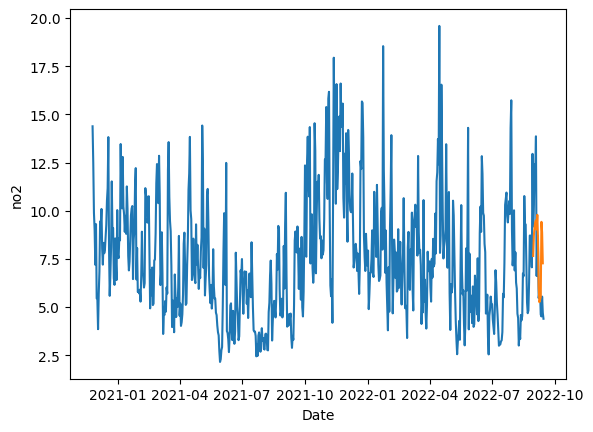

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'no2':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'no2']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['no2'])
sns.lineplot(df_forecast['Date'], df_forecast['no2'])


In [ ]:
df_forecast


,Date,no2
0,2022-08-30,7.649518
1,2022-08-31,8.738858
2,2022-09-01,9.148252
3,2022-09-02,9.406972
4,2022-09-03,9.508024
5,2022-09-04,9.026340
6,2022-09-05,9.785250
7,2022-09-06,8.529618
8,2022-09-07,6.046906
9,2022-09-08,5.251356


In [ ]:
original.tail(16)

,Date,no2
643,2022-08-30,9.18
644,2022-08-31,10.32
645,2022-09-01,12.42
646,2022-09-02,11.97
647,2022-09-03,13.86
648,2022-09-04,6.61
649,2022-09-05,8.73
650,2022-09-06,8.07
651,2022-09-07,5.46
652,2022-09-08,5.77


In [ ]:
org=original.tail(16).copy()
org=org.head(15)
org = org.reset_index()
org

,index,Date,no2
0,643,2022-08-30,9.18
1,644,2022-08-31,10.32
2,645,2022-09-01,12.42
3,646,2022-09-02,11.97
4,647,2022-09-03,13.86
5,648,2022-09-04,6.61
6,649,2022-09-05,8.73
7,650,2022-09-06,8.07
8,651,2022-09-07,5.46
9,652,2022-09-08,5.77


In [ ]:
predict_final = pd.DataFrame(columns=['Date','Actuall','Predicted','def','errorPersent'])
predict_final

,Date,Actuall,Predicted,def,errorPersent


In [ ]:
print(df_forecast.shape)
for i in range(df_forecast.shape[0]):
    def2=df_forecast['no2'][i]-org['no2'][i]
    if(def2<0):
        def2=def2*-1
    if(org['no2'][i]>df_forecast['no2'][i]):
        error=(def2/org['no2'][i])*100
    else:
        error=(def2/df_forecast['no2'][i])*100
    data1 = {
        "Date": [df_forecast['Date'][i]],
        "Actuall":org['no2'][i],
        "Predicted":df_forecast['no2'][i],
        "def":def2,
        "errorPersent":error
            }
    print(data1)
    data = pd.DataFrame(data1)

    predict_final = pd.concat([predict_final, data])
    

(15, 2)


KeyError: 'pm10'

In [ ]:
predict_final = predict_final.reset_index()
predict_final

,index,Date,Actuall,Predicted,def,errorPersent
0,0,2022-08-29,33.86,15.945948,17.914052,52.906238
1,0,2022-08-30,28.08,16.876726,11.203274,39.897699
2,0,2022-08-31,29.57,18.004913,11.565087,39.110878
3,0,2022-09-01,27.80,17.737740,10.062260,36.195181
4,0,2022-09-02,22.48,9.466792,13.013208,57.887935
5,0,2022-09-03,11.27,9.275324,1.994676,17.698990
6,0,2022-09-04,7.84,9.915886,2.075886,20.934952
7,0,2022-09-05,10.59,11.790570,1.200570,10.182461
8,0,2022-09-06,16.61,13.297774,3.312226,19.941154
9,0,2022-09-07,17.01,15.097633,1.912367,11.242602


In [ ]:
print("Total error persentage : ",(predict_final['errorPersent'].sum())/15)
print('model accurace : ',100-(predict_final['errorPersent'].sum())/15)

Total error persentage :  33.05461251926457
model accurace :  66.94538748073543


#so2

In [ ]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,1]

C:\Users\HAPPY\AppData\Local\Temp\ipykernel_19012\3510996120.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\HAPPY\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`,

<AxesSubplot:xlabel='Date', ylabel='so2'>

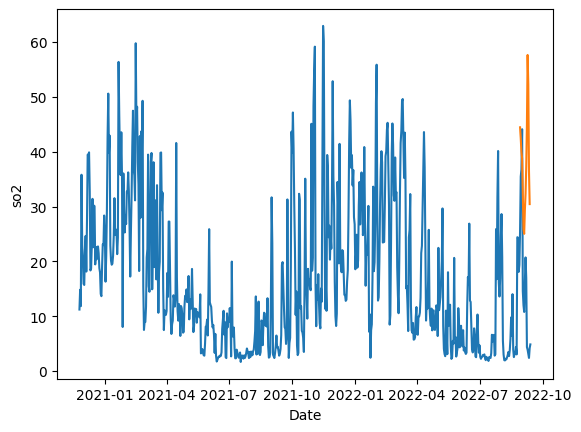

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'so2':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'so2']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['so2'])
sns.lineplot(df_forecast['Date'], df_forecast['so2'])


In [ ]:
df_forecast

,Date,so2
0,2022-08-29,44.438084
1,2022-08-30,42.420460
2,2022-08-31,39.978439
3,2022-09-01,38.758266
4,2022-09-02,32.293030
5,2022-09-03,25.880966
6,2022-09-04,25.021093
7,2022-09-05,29.357855
8,2022-09-06,32.325104
9,2022-09-07,37.270782


In [ ]:
original.tail(16)

,Date,so2
642,2022-08-29,25.38
643,2022-08-30,35.47
644,2022-08-31,36.73
645,2022-09-01,44.09
646,2022-09-02,14.58
647,2022-09-03,12.00
648,2022-09-04,10.78
649,2022-09-05,16.24
650,2022-09-06,20.72
651,2022-09-07,16.99


In [ ]:
org=original.tail(16).copy()
org=org.head(15)
org = org.reset_index()
org

,index,Date,so2
0,642,2022-08-29,25.38
1,643,2022-08-30,35.47
2,644,2022-08-31,36.73
3,645,2022-09-01,44.09
4,646,2022-09-02,14.58
5,647,2022-09-03,12.00
6,648,2022-09-04,10.78
7,649,2022-09-05,16.24
8,650,2022-09-06,20.72
9,651,2022-09-07,16.99


In [ ]:
predict_final = pd.DataFrame(columns=['Date','Actuall','Predicted','def','errorPersent'])
predict_final

,Date,Actuall,Predicted,def,errorPersent


In [ ]:
print(df_forecast.shape)
for i in range(df_forecast.shape[0]):
    def2=df_forecast['so2'][i]-org['so2'][i]
    if(def2<0):
        def2=def2*-1
    if(org['so2'][i]>df_forecast['so2'][i]):
        error=(def2/org['so2'][i])*100
    else:
        error=(def2/df_forecast['so2'][i])*100
    data1 = {
        "Date": [df_forecast['Date'][i]],
        "Actuall":org['so2'][i],
        "Predicted":df_forecast['so2'][i],
        "def":def2,
        "errorPersent":error
            }
    print(data1)
    data = pd.DataFrame(data1)

    predict_final = pd.concat([predict_final, data])
    


In [ ]:
predict_final = predict_final.reset_index()
predict_final

,index,Date,Actuall,Predicted,def,errorPersent


In [ ]:
print("Total error persentage : ",(predict_final['errorPersent'].sum())/15)
print('model accurace : ',100-(predict_final['errorPersent'].sum())/15)

Total error persentage :  0.0
model accurace :  100.0
